**IMPORTS**

In [1]:
!pip install ipyplot -q

import pandas as pd
import numpy as np
from fastai.vision.all import *
import ipyplot
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = Path('../input/hpa-single-cell-image-classification')
df_train = pd.read_csv(path/'train.csv')
df_sub = pd.read_csv(path/'sample_submission.csv')

In [2]:
df_train

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0
...,...,...
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,14
21802,dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0,3|0
21803,dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0,14|0
21804,df573730-bbca-11e8-b2bc-ac1f6b6435d0,14


In [3]:
mt = [path/'train'/(id+'_red.png') for id in df_train.ID.values]
er = [path/'train'/(id+'_yellow.png') for id in df_train.ID.values]
nu = [path/'train'/(id+'_blue.png') for id in df_train.ID.values]
pr = [path/'train'/(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

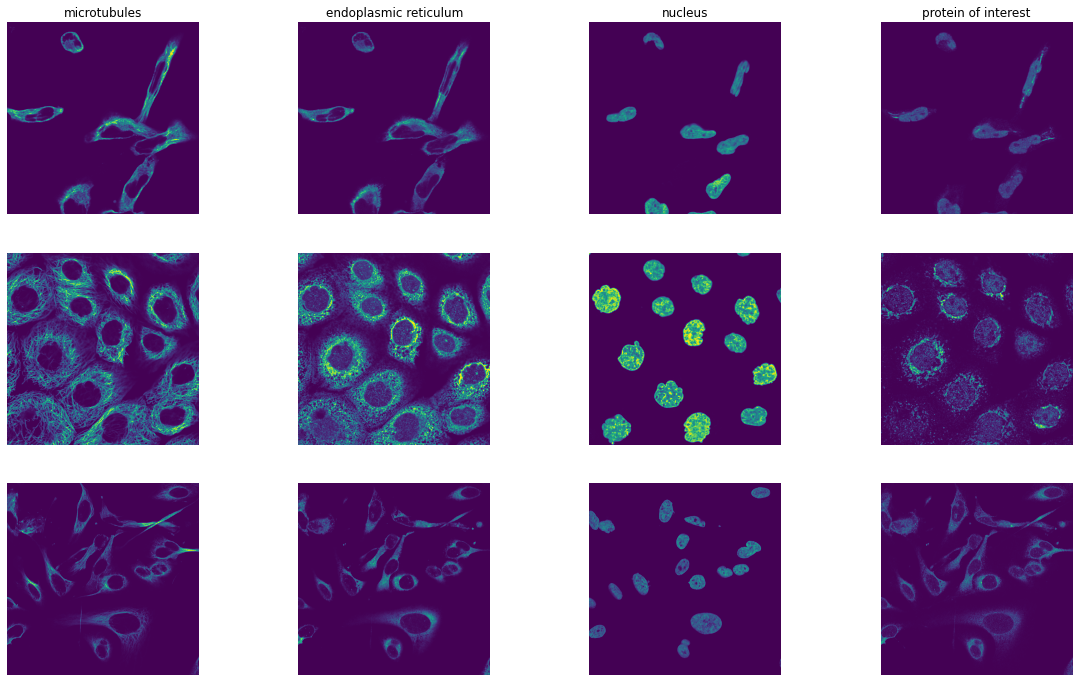

In [4]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

In [5]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

     / 17 kB 115 kB/s
     | 131 kB 214 kB/s
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14917 sha256=e12e20f4586c0e8d3e6f3f0efea3f55cec2f659b5b7c4908a3df8633b54b4ba5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb6mbybr/wheels/cd/d8/de/04ad08802d62537f8dffc89b6a7ce0a53c3d29ea6eae522ab1
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=bf17d81f1044080326f99ec646f520a1615267f503c4f645c96e8e51489eaaf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-qb6mbybr/wheels/58/0e/c7/567928a140c7cb2533c59bdc81fded8fe720ea8caad1659d8c
Successfully built hpacellseg pytorch-zoo


In [6]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob

NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

Could not find ./nuclei-model.pth. Downloading it now


please compile abn


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [7]:
train_df = df_train.copy()
# basic 
import warnings
import os, gc, cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

# segmentation tool
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

%matplotlib inline
warnings.filterwarnings('ignore')

ROOT = '../input/hpa-single-cell-image-classification/'


**Clean Data + Load Segmentator**

In [8]:
# spliting label column
train_df["Label"] = train_df["Label"].str.split("|")

# class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']

# binarizing each label/class
for label in tqdm(class_labels):
    train_df[label] = train_df['Label'].map(lambda result: 1 if label in result else 0)

# rename column
train_df.columns = ['ID', 'Label', 'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
                    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Intermediate filaments',
                    'Actin filaments', 'Microtubules', 'Mitotic spindle', 'Centrosome', 'Plasma membrane', 'Mitochondria',
                    'Aggresome', 'Cytosol', 'Vesicles and punctate cytosolic patterns', 'Negative']
train_df['lengths'] = train_df['Label'].str.len()
train_df

  0%|          | 0/19 [00:00<?, ?it/s]

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative,lengths
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,"[8, 5, 0]",1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,"[6, 1]",0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,"[16, 10]",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,2
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,[14],0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
21802,dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0,"[3, 0]",1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
21803,dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
21804,df573730-bbca-11e8-b2bc-ac1f6b6435d0,[14],0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [9]:
NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cpu",
    padding=False,
    multi_channel_model=True,
)

In [10]:
# read and visualize sample image
def read_sample_image(filename):
    
    '''
    read individual images
    of different filters (R, G, B, Y)
    and stack them.
    ---------------------------------
    Arguments:
    filename -- sample image path
    
    Returns:
    stacked_images -- stacked (RGBY) image
    '''
    
    red = cv2.imread(os.path.join(ROOT, 'train/') + filename + "_red.png", cv2.IMREAD_UNCHANGED)
    green = cv2.imread(os.path.join(ROOT, 'train/') + filename + "_green.png", cv2.IMREAD_UNCHANGED)
    blue = cv2.imread(os.path.join(ROOT, 'train/') + filename + "_blue.png", cv2.IMREAD_UNCHANGED)
    yellow = cv2.imread(os.path.join(ROOT, 'train/') + filename + "_yellow.png", cv2.IMREAD_UNCHANGED)

    stacked_images = np.transpose(np.array([red, green, blue, yellow]), (1,2,0))
    return stacked_images

def plot_all(im, label):
    
    '''
    plot all RGBY image,
    Red, Green, Blue, Yellow, 
    filters images.
    --------------------------
    Argument:
    im - image
    '''
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 5, 1)
    plt.imshow(im[:,:,:3])
    plt.title('RGBY Image')
    plt.axis('off')
    plt.subplot(1, 5, 2)
    plt.imshow(im[:,:,0], cmap='Reds')
    plt.title('Microtubule channels')
    plt.axis('off')
    plt.subplot(1, 5, 3)
    plt.imshow(im[:,:,1], cmap='Greens')
    plt.title('Protein of Interest')
    plt.axis('off')
    plt.subplot(1, 5, 4)
    plt.imshow(im[:,:,2], cmap='Blues')
    plt.title('Nucleus')
    plt.axis('off')
    plt.subplot(1, 5, 5)
    plt.imshow(im[:,:,3], cmap='Oranges')
    plt.title('Endoplasmic Reticulum')
    plt.axis('off')
    plt.show()

# read and visualize sample image
def read_sample_image_seg(filename):
    
    '''
    read individual images
    of different filters (R, B, Y)
    and stack them for segmentation.
    ---------------------------------
    Arguments:
    filename -- sample image file path
    
    Returns:
    stacked_images -- stacked (RBY) image path in lists.
    '''
    
    red = os.path.join(ROOT, 'train/') + filename + "_red.png"
    blue = os.path.join(ROOT, 'train/') + filename + "_blue.png"
    yellow = os.path.join(ROOT, 'train/') + filename + "_yellow.png"

    stacked_images = [[red], [yellow], [blue]]
    return stacked_images, red, blue, yellow

# segment cell 
def segmentCell(image, segmentator):
    
    '''
    segment cell and nuclei from
    microtubules, endoplasmic reticulum,
    and nuclei (R, B, Y) filters.
    ------------------------------------
    Argument:
    image -- (R, B, Y) list of image arrays
    segmentator -- CellSegmentator class object
    
    Returns:
    cell_mask -- segmented cell mask
    '''
    
    nuc_segmentations = segmentator.pred_nuclei(image[2])
    cell_segmentations = segmentator.pred_cells(image)
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
    
    gc.collect(); del nuc_segmentations; del cell_segmentations; del nuclei_mask
    
    return cell_mask

# plot segmented cells mask, image
def plot_cell_segments(mask, red, blue, yellow):
    
    '''
    plot segmented cells
    and images
    ---------------------
    Arguments:
    mask -- cell mask
    red -- red filter image path
    blue -- blue filter image path
    yellow -- yellow filter image path
    '''
    microtubule = plt.imread(r)    
    endoplasmicrec = plt.imread(b)    
    nuclei = plt.imread(y)
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()

# plot single segmented cells mask, image
def plot_single_cell(mask, red, blue, yellow):
    
    '''
    plot single cell mask
    and image
    ---------------------
    Arguments:
    mask -- cell mask
    red -- red filter image path
    blue -- blue filter image path
    yellow -- yellow filter image path
    '''
    microtubule = plt.imread(r)    
    endoplasmicrec = plt.imread(b)    
    nuclei = plt.imread(y)
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    
    contours= cv2.findContours(mask.astype('uint8'),
                               cv2.RETR_TREE, 
                               cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) for c in contours[0]]
    x = np.argsort(areas)
    cnt = contours[0][x[-1]]
    x,yc,w,h = cv2.boundingRect(cnt)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img[yc:yc+h, x:x+w])
    plt.title('Cell Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask[yc:yc+h, x:x+w])
    plt.title('Cell Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img[yc:yc+h, x:x+w])
    plt.imshow(mask[yc:yc+h, x:x+w], alpha=0.6)
    plt.title('Cell Image + Mask')
    plt.axis('off')
    plt.show()
    
def binary_mask(rgby_images):
    
    '''
    generate masks from 
    rgby images.
    --------------------
    Arguments:
    rgby_images -- RGBY cell images
    
    Return:
    mask -- binary mask.
    '''
    pass

Nucleoplasm


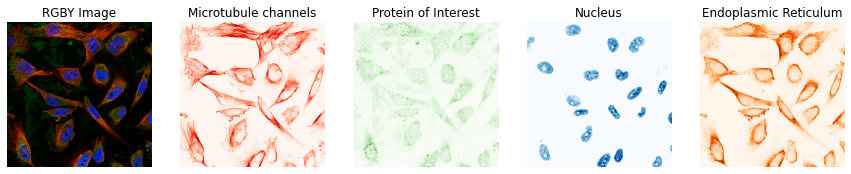

Nuclear membrane


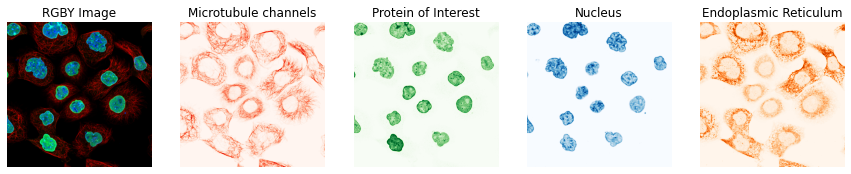

Nucleoli


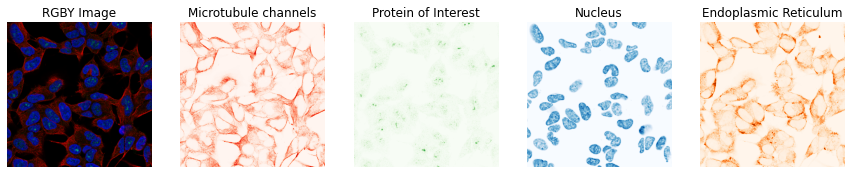

Nucleoli fibrillar center


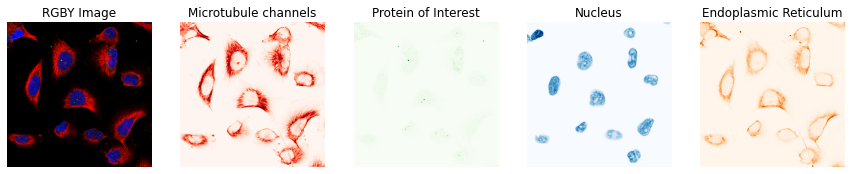

Nuclear speckles


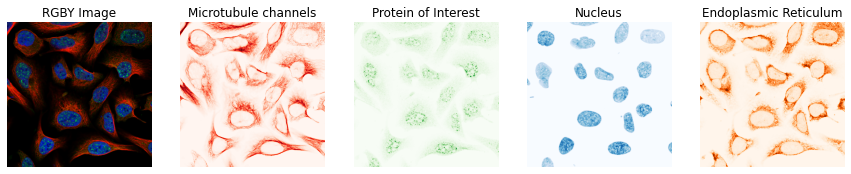

Nuclear bodies


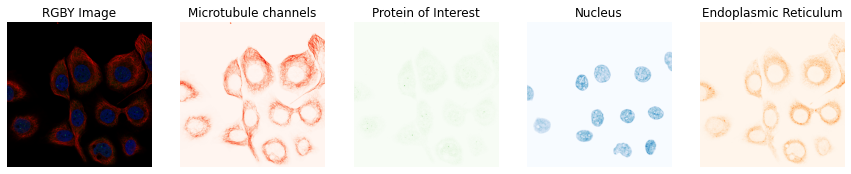

Endoplasmic reticulum


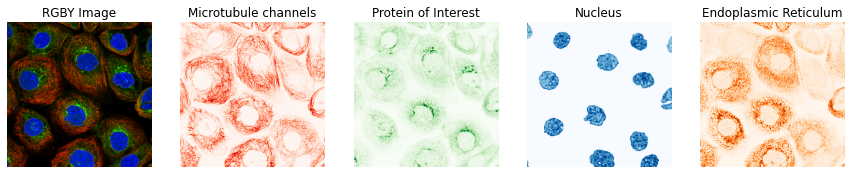

Golgi apparatus


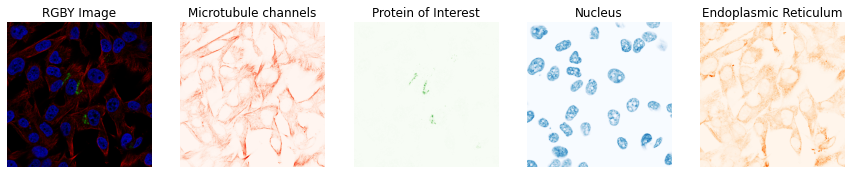

Intermediate filaments


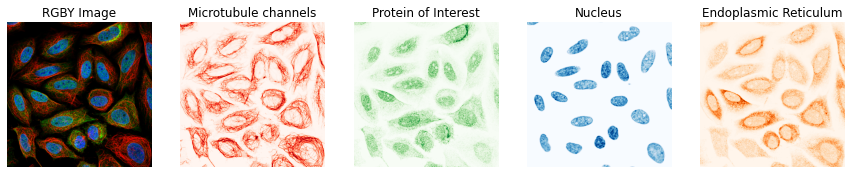

Actin filaments


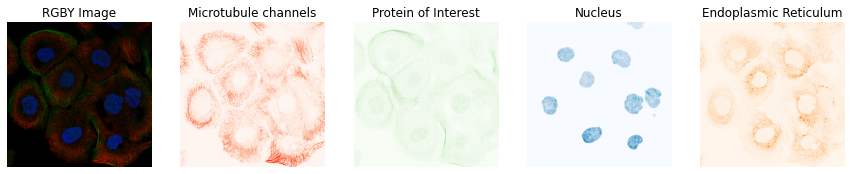

Microtubules


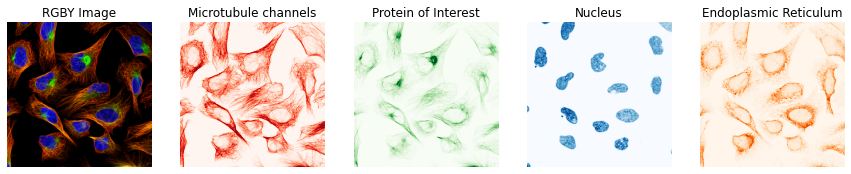

Mitotic spindle


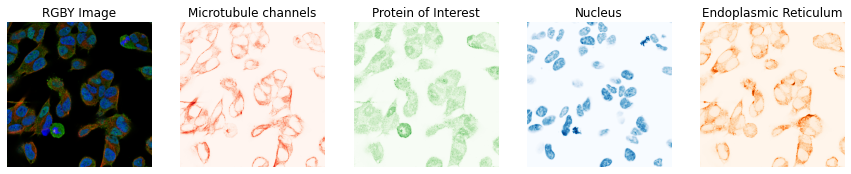

Centrosome


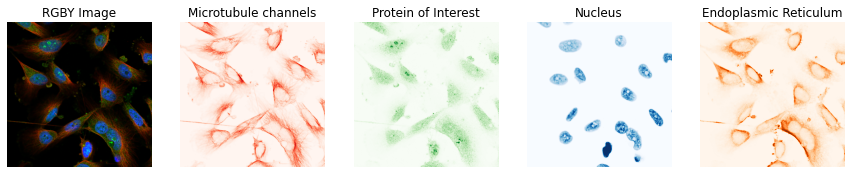

Plasma membrane


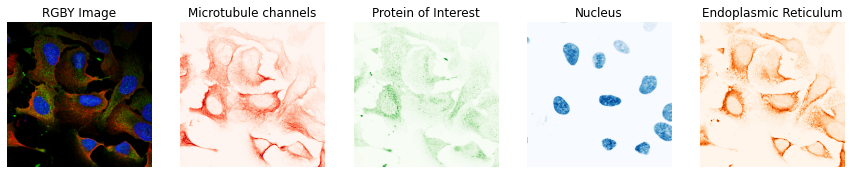

Mitochondria


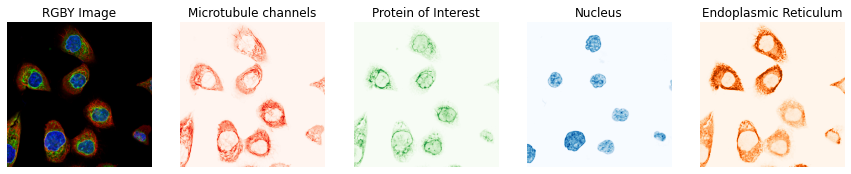

Aggresome


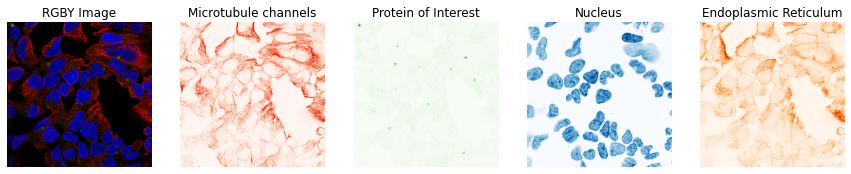

Cytosol


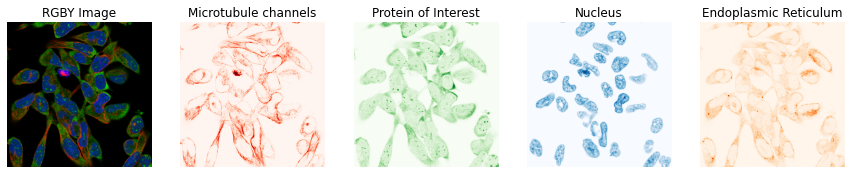

Vesicles and punctate cytosolic patterns


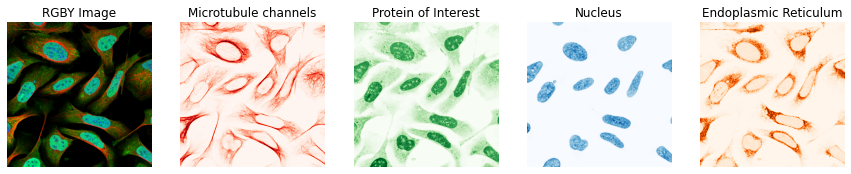

Negative


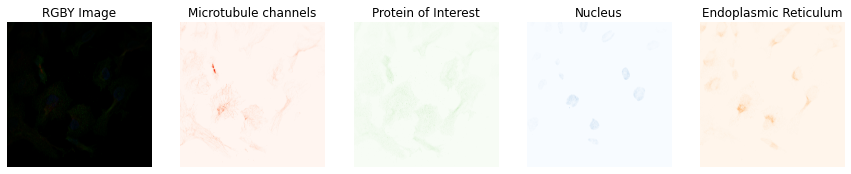

lengths


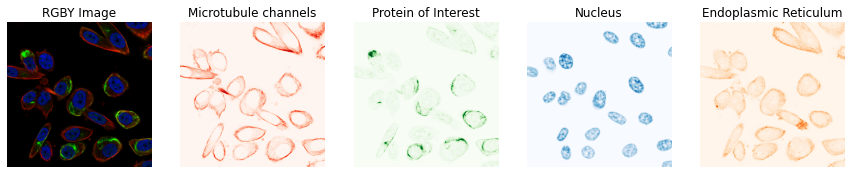

In [11]:
for label in train_df.drop(['ID', 'Label'], axis=1):
    print(label)
    im = read_sample_image(train_df[train_df[label]==1].sample(1).ID.to_string().split(' ')[4])
    plot_all(im, label)

In [12]:
label='Cytosol'
train_df[(train_df[label]==1) & (train_df['lengths'] == 1)].sample(100)

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative,lengths
7970,e82c6aca-bbab-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15134,eac08df6-bbbb-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
13638,8c0a3422-bbb8-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15665,1fa898b4-bbbd-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
11272,433f496c-bbb3-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6905,8c1ae196-bba9-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
12636,3ed6bd3a-bbb6-11e8-b2ba-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
21168,89b23ed4-bbc9-11e8-b2bc-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4564,6f58b1aa-bba4-11e8-b2b9-ac1f6b6435d0,[16],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [13]:
trunk_df = train_df[(train_df[label]==1) & (train_df['lengths'] == 1)].sample(100)['ID'].str.split().reset_index(drop=True)
trunk_df_list = trunk_df.apply(pd.Series).stack().reset_index(drop=True).tolist()

In [14]:
plt.figure(figsize=(15, 50))
i=0
cellwise_intensity_thresholds = {}
for image in trunk_df_list:
    #obtain images for each channel
    first_image_blue = os.path.join(ROOT, 'train/') + image + "_blue.png"
    first_image_red = os.path.join(ROOT, 'train/') + image + "_red.png"
    first_image_yellow = os.path.join(ROOT, 'train/') + image + "_yellow.png"
    first_image_green = os.path.join(ROOT, 'train/') + image + "_green.png"
    #stack channels to form blended IMAGE
    stacked_images = [[first_image_red], [first_image_yellow], [first_image_blue]]
    #obtain cell and nuclei masks
    nuc_segmentations = segmentator.pred_nuclei([first_image_blue])
    cell_segmentations = segmentator.pred_cells(stacked_images)
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
    
    gc.collect(); del nuc_segmentations; del cell_segmentations
    
    microtubule = plt.imread(first_image_red)    
    endoplasmicrec = plt.imread(first_image_blue)    
    nuclei = plt.imread(first_image_yellow)    
    #protein = plt.imread(first_image_green)
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    #threshold intensities
    protein = cv2.imread(first_image_green, 0)
    dst = cv2.medianBlur(protein,7)
    thresh = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,75,-20)

    #store cellwise intensities for each image
    intensities = []
    for i in range (1,np.max(nuclei_mask)+1):
        cell2_cell = (cell_mask == i)
        intensities.append(np.mean(thresh[cell2_cell]))
    cellwise_intensity_thresholds[image] = intensities
    
    i=i+1
    print(i)
    #plt.subplot(10,3,i)
    #plt.imshow(thresh, cmap='Blues')
    #plt.imshow(cell_mask, cmap='gray', alpha=0.5)
    
    
    
    
    

45
10
31
16
53
35
23
25
33
27
21
50
35
29
21
9
33
13
13
48
22
34
19
44
16
19
30
26
15
40
15
24
15
25
12
19
16
17
33
11
20
24
17
13
9
11
41
8
38
24
20
23
17
25
31
45
13
48
22
48
25
19
40
18
17
16
19
13
12
16
39
25
54
73
19
19
31
29
11
16
13
11
30
13
22
10
70
13
14
10
14
5
50
62
28
26
37
24
24
17


<Figure size 1080x3600 with 0 Axes>

first_image_test = trunk_df_list[3]
first_image_blue = os.path.join(ROOT, 'train/') + first_image_test + "_blue.png"
first_image_red = os.path.join(ROOT, 'train/') + first_image_test + "_red.png"
first_image_yellow = os.path.join(ROOT, 'train/') + first_image_test + "_yellow.png"
first_image_green = os.path.join(ROOT, 'train/') + first_image_test + "_green.png"

stacked_images = [[first_image_red], [first_image_yellow], [first_image_blue]]

nuc_segmentations = segmentator.pred_nuclei([first_image_blue])
cell_segmentations = segmentator.pred_cells(stacked_images)
nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
    
gc.collect(); del nuc_segmentations; del cell_segmentations

microtubule = plt.imread(first_image_red)    
endoplasmicrec = plt.imread(first_image_blue)    
nuclei = plt.imread(first_image_yellow)    
protein = plt.imread(first_image_green)
img = np.dstack((microtubule, endoplasmicrec, nuclei))

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cell_mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(img)
plt.imshow(cell_mask, alpha=0.6)
plt.title('Image + Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(nuclei_mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img)
plt.imshow(nuclei_mask, alpha=0.6)
plt.title('Image + Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(img)
plt.imshow(nuclei_mask, alpha=0.6)
plt.title('Image + Mask')
plt.axis('off')
plt.show()

plt.imshow(protein)

number = 11
cell2_nucleus = (nuclei_mask == number)
cell2_cell = (cell_mask == number)
plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(cell2_cell, cmap='gray')
plt.subplot(1,3,2)
protein = cv2.imread(first_image_green, 0)
#protein_normalized = cv2.normalize(protein2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)#, dtype=cv2.CV_16UC1)
plt.imshow(protein, cmap='Blues')
plt.subplot(1,3,3)

dst = cv2.medianBlur(protein,5)
#ret,thresh = cv2.threshold(protein,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
#thresh = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,61,-15)
thresh = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,75,-20)
    
plt.imshow(thresh, cmap='Blues')



plt.imshow(cell2_cell, cmap='gray', alpha=0.5)
#plt.imshow(protein, cmap='Blues', alpha=0.5)

np.max(nuclei_mask)

number = 3
cell2_nucleus = (nuclei_mask == number)
cell2_cell = (cell_mask == number)
plt.figure(figsize=(15, 10))

plt.subplot(1,4,1)
plt.imshow(cell2_cell, cmap='gray')
plt.subplot(1,4,2)
protein = cv2.imread(first_image_green, 0)

plt.imshow(protein, cmap='Blues')
plt.subplot(1,4,3)

dst = cv2.medianBlur(protein,7)
thresh = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,75,-20)
    
plt.imshow(thresh, cmap='Blues')
plt.subplot(1,4,4)
plt.imshow(img)

intensities = []
for i in range (1,np.max(nuclei_mask)+1):
    cell2_cell = (cell_mask == i)
    intensities.append(np.mean(thresh[cell2_cell]))

intensities

protein

In [15]:
protein_normalized

NameError: name 'protein_normalized' is not defined

protein_normalized